# Прокси-модель ГДМ

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Ridge, SGDRegressor, GammaRegressor, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Выгружаем исходные данные, выбираем период, на котором велась активная разрабтка

In [3]:
raw = pd.read_csv('wbp.csv', index_col=0, parse_dates=True)
raw = raw.loc['2015-08-01':]

### Модель по определенной скважине

In [5]:
well = '0001'

Выделяем данные по одной скважине, разделяем на признаковое пространство и целевую метку

In [6]:
data = raw.loc[:, ['WGPT:' + str(well), 'WBP:' + str(well)]]
data.columns = ['WGPT', 'WBP']
X = data.loc[:, ['WGPT']]
y = data.loc[:, ['WBP']]

In [7]:
days = []
for datetime in data.index:
    days.append((datetime - data.index[0]).days)
X['DAYS'] = days

In [8]:
def features_transform(X):
    days = []
    for datetime in X.index:
        days.append((datetime - X.index[0]).days)
    X['DAYS'] = days
    
    X['QDAY'] = X['WGPT'].diff()
    X['DIFF_QDAY'] = X.loc[:, 'QDAY'].diff()
    
    state = 0
    states = []
    for i in X.index:
        if X.loc[i]['QDAY'] < 100:
            if state == 0:
                state = 1
            elif state > 0:
                state += 1
        else:
            state = 0
        states.append(state)
    X['cumstate_shut_down'] = states
    
    state = 0
    states = []
    for i in X.index:
        if X.loc[i]['QDAY'] > 100:
            if state == 0:
                state = 1
            elif state > 0:
                state += 1
        else:
            state = 0
        states.append(state)
    X['cumstate_production'] = states
    
    days = [1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 30]
    for day in days:
        X['QDAY_SUM_' + str(day)] = X['QDAY'].rolling(day).sum()/day
        X['DIFF_QDAY_SUM_' + str(day)] = X['DIFF_QDAY'].rolling(day).sum()/day
        X['QDAY_MEAN_' + str(day)] = X['QDAY'].rolling(day).mean()/day
        X['DIFF_QDAY_MEAN_' + str(day)] = X['DIFF_QDAY'].rolling(day).mean()/day
        X['QDAY_MIN_' + str(day)] = X['QDAY'].rolling(day).min()/day
        X['DIFF_QDAY_MIN_' + str(day)] = X['DIFF_QDAY'].rolling(day).min()/day
        X['QDAY_MAX_' + str(day)] = X['QDAY'].rolling(day).max()/day
        X['DIFF_QDAY_MAX' + str(day)] = X['DIFF_QDAY'].rolling(day).max()/day
    X.dropna(inplace=True)
    return X.iloc[[-1]]

In [9]:
X['QDAY'] = X['WGPT'].diff()
X['DIFF_QDAY'] = X.loc[:, 'QDAY'].diff()

In [10]:
state = 0
states = []
for i in X.index:
    if X.loc[i]['QDAY'] < 100:
        if state == 0:
            state = 1
        elif state > 0:
            state += 1
    else:
        state = 0
    states.append(state)
X['cumstate_shut_down'] = states

In [11]:
state = 0
states = []
for i in X.index:
    if X.loc[i]['QDAY'] > 100:
        if state == 0:
            state = 1
        elif state > 0:
            state += 1
    else:
        state = 0
    states.append(state)
X['cumstate_production'] = states

In [12]:
days = [1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 30]
for day in days:
    X['QDAY_SUM_' + str(day)] = X['QDAY'].rolling(day).sum()/day
    X['DIFF_QDAY_SUM_' + str(day)] = X['DIFF_QDAY'].rolling(day).sum()/day
    X['QDAY_MEAN_' + str(day)] = X['QDAY'].rolling(day).mean()/day
    X['DIFF_QDAY_MEAN_' + str(day)] = X['DIFF_QDAY'].rolling(day).mean()/day
    X['QDAY_MIN_' + str(day)] = X['QDAY'].rolling(day).min()/day
    X['DIFF_QDAY_MIN_' + str(day)] = X['DIFF_QDAY'].rolling(day).min()/day
    X['QDAY_MAX_' + str(day)] = X['QDAY'].rolling(day).max()/day
    X['DIFF_QDAY_MAX' + str(day)] = X['DIFF_QDAY'].rolling(day).max()/day

In [13]:
X.dropna(inplace=True)

In [15]:
y = y.loc[X.index]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.05)

In [17]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

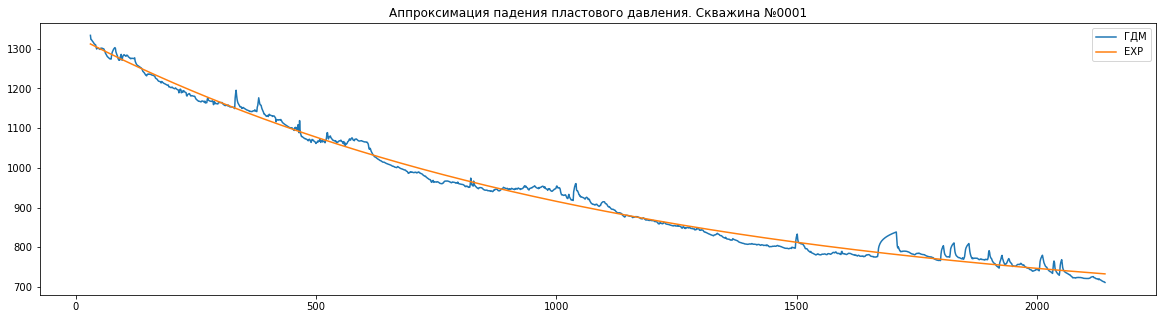

In [28]:
xdata = X_train.DAYS.values
ydata = y_train.WBP.values
plt.figure(figsize=(20, 5))
plt.plot(xdata, ydata, label='ГДМ')

popt, pcov = curve_fit(func, xdata, ydata, maxfev=100, 
                     bounds=(0, [2000., 0.1, 2000.])
                      )
plt.plot(xdata, func(xdata, *popt), label='EXP')

plt.legend()
plt.title('Аппроксимация падения пластового давления. Скважина №' + str(well))
plt.show()

In [29]:
X_test.loc[:, 'EXP_PRED'] = func(X_test.DAYS.values, *popt)
X_train.loc[:, 'EXP_PRED'] = func(X_train.DAYS.values, *popt)
X.loc[:, 'EXP_PRED'] = func(X.DAYS.values, *popt)

C:\Users\ivan\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\ivan\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [30]:
models = [LinearRegression(), ARDRegression(), BayesianRidge(), Ridge(),
          SGDRegressor(), GammaRegressor(), HuberRegressor(), CatBoostRegressor(silent=True),
          StackingRegressor([('ARDR', ARDRegression()), ('CBR', CatBoostRegressor(silent=True))], final_estimator=LinearRegression())]

In [31]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('poly', PolynomialFeatures(degree=1)),
                     ('model', models[8])])
pipeline_lin = Pipeline([('scaler', StandardScaler()),
                     ('poly', PolynomialFeatures(degree=1)),
                     ('model', models[1])])
pipeline_CBR = Pipeline([('scaler', StandardScaler()),
                     ('poly', PolynomialFeatures(degree=1)),
                     ('model', models[7])])

In [33]:
pipeline.fit(X_train, y_train.values.ravel())
pipeline_lin.fit(X_train, y_train.values.ravel())
pipeline_CBR.fit(X_train, y_train.values.ravel())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x0000013DA15D3760>)])

In [36]:
print('MAE', mean_absolute_error(y_test, pipeline_lin.predict(X_test)))
print('MAPE', mean_absolute_percentage_error(y_test, pipeline_lin.predict(X_test)) * 100)
print('RMSE', np.sqrt(mean_squared_error(y_test, pipeline_lin.predict(X_test))))
print('R2', r2_score(y_test, pipeline_lin.predict(X_test)))

MAE 1.6864690185932016
MAPE 0.23580821851366096
RMSE 1.858223713680248
R2 0.8585646583639511


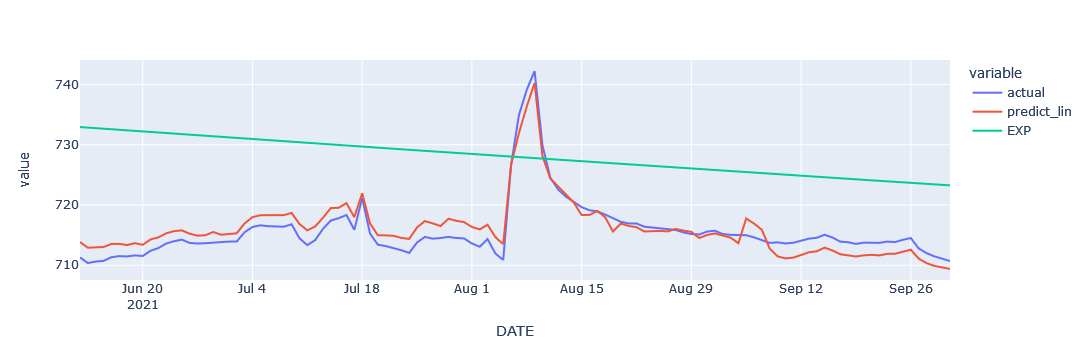

In [39]:
plot = pd.DataFrame(index = y_test.index)
plot['actual'] = y_test
# plot['predict_stack'] = pipeline.predict(X)
plot['predict_lin'] = pipeline_lin.predict(X_test)
# plot['predict_CBR'] = pipeline_CBR.predict(X)
plot['EXP'] = X['EXP_PRED']
px.line(plot)

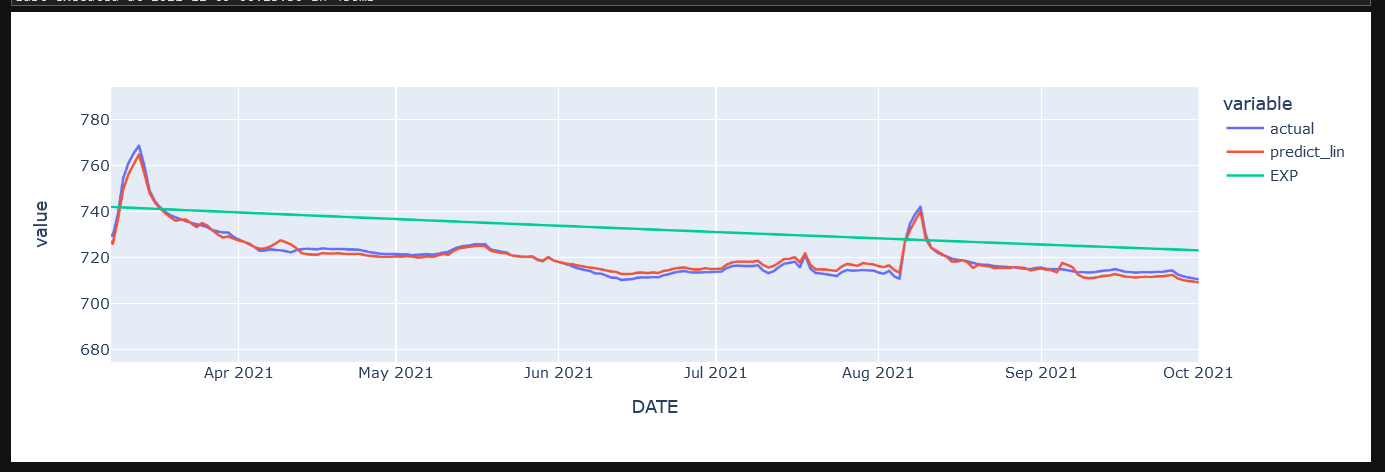